# Using Spotify API and Machine Learning

## This Jupyter Notebook is meant for Exploratory Data Analysis into my own Spotify Playlists and seeing what is availble to develop a recommender.

In [1]:
import spotipy as sp
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials

import pandas as pd
from sklearn import preprocessing

## Spotify Authorization Flow via Spotipy API

In [2]:
client_id = "7d5c137ab5154cf1a3ff64ae97a85c74"
secret = "7bf61d8df66b4b6e98881d94721f095c"
redirect = "http://localhost:7777/callback"
scope = "user-read-recently-played%20playlist-read-private"


auth = SpotifyOAuth(scope = scope,
                    redirect_uri = redirect,
                    client_id = client_id,
                    client_secret = secret,
                    username = 'ywze3yhb7ati7k9lxo6pwlori')

sp = sp.Spotify(auth_manager = auth)


## Get User Followed Playlist
### Also getting the songs from those playlists and storing the song_id in a list

In [3]:
playlists_resp = sp.current_user_playlists()

song_list = list()

for item in playlists_resp['items']:
    list_id = item['id']

    offset = 0
    while True:
        song_resp = sp.playlist_items(playlist_id = list_id, offset = offset, limit = None)
        
        for song in song_resp['items']:
            song_list.append(song['track']['id'])

        # Offset is here because it can only send 100 songs at a time
        if song_resp['next'] is None:
            break
        else:
            offset += 100
print('-------------------------------------------')
print(len(song_list))
print(len(playlists_resp['items']))
num_playlists = len(playlists_resp['items'])

-------------------------------------------
590
11


In [4]:
playlists = sp.featured_playlists(limit = 50)
print(playlists)

{'message': 'Selección del editor', 'playlists': {'href': 'https://api.spotify.com/v1/browse/featured-playlists?timestamp=2021-08-10T02%3A11%3A47&offset=0&limit=50', 'items': [{'collaborative': False, 'description': 'Gentle ambient piano to help you fall asleep.', 'external_urls': {'spotify': 'https://open.spotify.com/playlist/37i9dQZF1DWZd79rJ6a7lp'}, 'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DWZd79rJ6a7lp', 'id': '37i9dQZF1DWZd79rJ6a7lp', 'images': [{'height': None, 'url': 'https://i.scdn.co/image/ab67706f00000003b70e0223f544b1faa2e95ed0', 'width': None}], 'name': 'Sleep', 'owner': {'display_name': 'Spotify', 'external_urls': {'spotify': 'https://open.spotify.com/user/spotify'}, 'href': 'https://api.spotify.com/v1/users/spotify', 'id': 'spotify', 'type': 'user', 'uri': 'spotify:user:spotify'}, 'primary_color': None, 'public': None, 'snapshot_id': 'MTYyNTU2NTY5MSwwMDAwMDBkMDAwMDAwMTdhN2I0M2ZkMDEwMDAwMDE2Y2Y2OTUyYjAw', 'tracks': {'href': 'https://api.spotify.com/v1/playlis

## Getting the Audio Features from Spoitfy API

In [5]:
audio_feat = list()

# print(song_list)
i = 0
while i < len(song_list):
    # print(sp.audio_features(i))
    try:
        curr = song_list[i]
        audio_feat.append(sp.audio_features(curr)[0])
        i += 1
    except:
        i += 2

features_list = list()

for features in audio_feat:
    try:
        features_list.append([features['danceability'], features['energy'], features['key'],                                                    features['loudness'], features['mode'], features['speechiness'], 
                                features['acousticness'], features['instrumentalness'], 
                                features['liveness'], features['valence'], features['tempo'],                                                   features['id']])
    except:
        break

features_df = pd.DataFrame(features_list, columns = ['danceability', 'energy', 'key',                                                                                'loudness', 'mode', 'speechiness',                                                                              'acousticness',  'instrumentalness',                                                                            'liveness', 'valence', 'tempo', 'id'])

# print(features_df)

## Feature Selection and ML

In [6]:
import itertools
from sklearn.cluster import KMeans
from sklearn import metrics

import matplotlib.pyplot as plt

feature_vals = features_df[['danceability', 'energy', 'key',                                                                                'loudness', 'mode', 'speechiness',                                                                              'acousticness',  'instrumentalness',                                                                            'liveness', 'valence', 'tempo']]

cols = ['danceability', 'energy', 'key',                                                                                'loudness', 'mode', 'speechiness',                                                                              'acousticness',  'instrumentalness',                                                                            'liveness', 'valence', 'tempo']
x = feature_vals.values
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)

scaled_df = pd.DataFrame(x_scaled, columns = cols)

print(scaled_df)


     danceability    energy       key  loudness  mode  speechiness  \
0        0.494135  0.775616  0.090909  0.752245   1.0     0.052597   
1        0.442815  0.968872  0.727273  0.866504   1.0     0.077489   
2        0.784457  0.897536  0.090909  0.748885   1.0     0.621212   
3        0.422287  0.970169  0.000000  0.794948   0.0     0.192641   
4        0.447214  0.713359  1.000000  0.840315   0.0     0.792208   
5        0.750733  0.833982  0.090909  0.715221   1.0     0.551948   
6        0.592375  0.607004  0.090909  0.718408   0.0     0.041342   
7        0.453079  0.645914  0.818182  0.777739   1.0     0.281385   
8        0.532258  0.714656  0.909091  0.614694   0.0     0.279221   
9        0.406158  0.826200  0.090909  0.879715   1.0     0.103247   
10       0.878299  0.683528  0.090909  0.671939   1.0     0.543290   
11       0.565982  0.679637  0.000000  0.694015   1.0     0.456710   
12       0.913490  0.360571  0.727273  0.632713   1.0     0.320346   
13       0.740469  0

## Looking at the Correlation Between Features

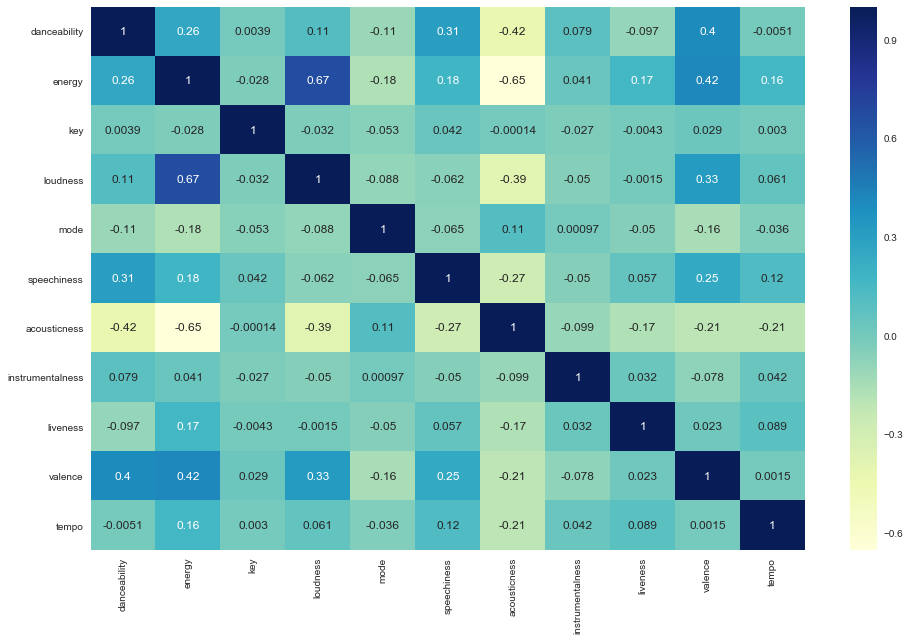

In [24]:
import seaborn as sb

fig, ax = plt.subplots(figsize = (16, 10))
hmp = sb.heatmap(scaled_df.corr(), cmap = "YlGnBu", annot = True)

### PCA to reduce the number of Features

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95)
pca_feats = pca.fit_transform(scaled_df)

# pca_feats_df = pd.DataFrame(data = pca_feats, columns = ['feat_1', 'feat_2', 'feat_3'])

print(f'Explained Variance = {sum(pca.explained_variance_ratio_)}')
# print(len(pca_feats[0]))
print(f'Number of Components for 95% Explained Variance = {len(pca_feats[0])}')
# pca_feats_df.head()

Explained Variance = 0.9623992359143885
Number of Components for 95% Explained Variance = 8


In [36]:
pca_df = pd.DataFrame(data = pca_feats, columns = ['comp_1', 'comp_2', 'comp_3', 'comp_4', 'comp_5', 'comp_6', 
                        'comp_7', 'comp_8'])
pca_df.head(10)

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8
0,-0.221978,-0.447406,-0.341162,0.271942,-0.094490,0.149229,-0.234128,-0.081274
1,-0.220145,-0.338034,0.264687,0.624477,-0.125935,0.028330,0.066158,-0.038138
2,-0.093831,-0.732099,-0.291954,-0.238305,0.100325,0.339517,0.149220,0.062716
3,0.785686,-0.289257,-0.506197,0.358623,-0.201559,0.369127,0.198206,0.445441
4,0.670574,0.291556,0.501614,-0.109465,0.160397,0.711423,0.116980,-0.227372
5,-0.171123,-0.602802,-0.313333,0.129235,0.312311,0.077190,0.134871,-0.160140
6,0.663396,-0.003621,-0.425527,0.348789,0.110633,-0.104924,-0.146164,-0.036396
7,-0.219840,-0.234332,0.395212,-0.049239,-0.109499,0.355047,-0.156058,-0.128809
8,0.767340,-0.059795,0.405582,0.220145,0.044424,-0.000573,0.258057,0.192436
9,-0.266757,-0.351537,-0.358046,0.453332,-0.088332,0.057553,-0.003807,-0.147300


### Elbow Method to determine the Optimal Amount of Clusters

[[2, 248.24314320887882], [3, 204.18387060968945], [4, 182.14210510543523], [5, 164.23486592063574], [6, 153.69729147225132], [7, 144.06565057924504], [8, 138.08951534718358], [9, 132.25870199643236], [10, 126.95408479225611], [11, 122.67924347916933]]


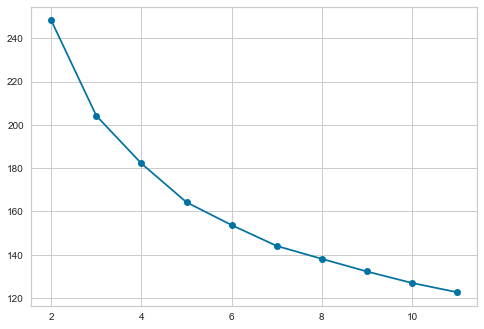

In [37]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Elbow Method for to find ideal number of clusters
# using number of playlists as the upper max for k

# perm_out = list()

inertia = list()
for i in range(2, num_playlists + 1):
    model = KMeans(n_clusters = i)
    model.fit(pca_df)

    inertia.append([i, model.inertia_])

print(inertia)

from kneed import KneeLocator

clusters = [i[0] for i in inertia]
iner = [i[1] for i in inertia]

k = KneeLocator(clusters, iner, curve = 'convex', direction = 'decreasing')
print(k)

plt.plot(clusters, iner, '-o')
plt.show()

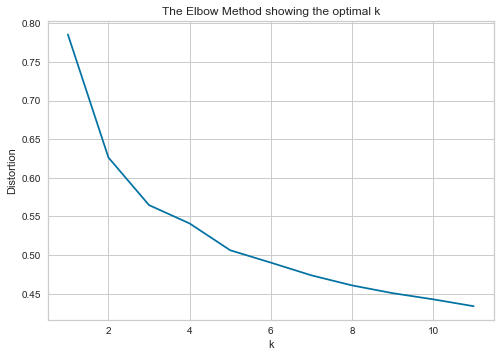

In [39]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = list()

K = range(1, num_playlists + 1)
for k in K:
    kmm = KMeans(n_clusters = k).fit(pca_df)
    # kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(pca_df, kmm.cluster_centers_, 'euclidean'), axis = 1)) / pca_df.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### Number of Clusters Should be 5

In [40]:
act_model = KMeans(n_clusters = 5)
act_model.fit(pca_df)

print(act_model.labels_)
print(act_model.cluster_centers_)

[1 3 1 2 0 1 2 3 0 1 1 1 3 3 1 1 1 3 0 3 3 0 1 1 3 3 4 4 4 4 4 4 4 4 4 0 4
 4 1 4 4 4 4 2 4 4 4 4 4 4 4 4 4 0 4 4 3 1 2 0 0 0 0 3 2 3 3 0 0 1 3 3 3 2
 3 0 1 3 2 4 0 4 3 4 4 3 3 2 3 1 4 4 3 2 2 4 1 1 2 1 1 3 4 4 3 3 4 2 2 4 2
 2 2 4 4 1 4 1 3 2 3 4 2 4 4 3 3 1 1 4 3 3 4 3 2 0 1 2 1 1 3 1 1 2 2 4 3 1
 4 1 4 4 2 3 4 4 0 4 0 3 3 1 4 2 3 1 3 1 4 1 0 0 3 4 4 3 3 0 2 1 4 1 4 3 3
 3 0 4 3 4 2 0 1 3 3 4 3 3 0 3 4 3 2 2 4 0 4 3 2 3 1 0 2 0 2 4 3 4 4 0 4 2
 1 1 1 2 3 1 4 2 0 4 3 1 2 4 4 3 1 3 3 1 2 4 3 1 2 2 4 2 4 1 0 0 3 0 2 2 0
 4 4 4 2 3 0 2 4 3 4 1 1 3 4 0 3 4 2 2 2 4 4 1 1 0 2 3 1 4 2 1 0 2 3 0 0 2
 2 2 2 4 2 4 2 4 0 4 1 3 2 4 4 3 4 4 3 4 0 1 4 4 3 4 0 2 1 4 3 0 3 4 4 1 2
 4 1 1 2 2 3 3 1 2 0 4 4 1 2 1 0 4 2 3 0 4 4 2 4 2 1 1 1 4 4 2 4 3 4 4 1 4
 1 2 4 3 3 4 1 1 4 3 1 3 4 2 3 4 2 3 0 1 0 2 3 1 1 2 4 3 4 1 0 3 4 2 4 4 2
 4 1 4 4 3 1 2 1 0 2 4 2 2 1 0 1 1 3 1 3 4 2 1 0 0 2 4 2 2 3 4 4 1 4 4 2 3
 4 4 1 3 3 2 2 0 1 0 2 2 4 4 0 1 2 2 1 0 3 3 1 0 0 4 3 4 1 2 2 3 0 2 1 3 0
 3 1 1 1 0 0 3 3 3 0 0 0 

## Getting the Featured Playlists
### Building out the Actual Recommender

In [15]:
new_playlists = sp.featured_playlists(limit = 10)
new_playlists = new_playlists['playlists']
# print(new_playlists)

new_songs = list()

for item in new_playlists['items']:
    list_id = item['id']
    # print(list_id)
    offset = 0
    while True:
        song_resp = sp.playlist_items(playlist_id = list_id, offset = offset, limit = None)
        # print(song_resp)
        for song in song_resp['items']:
            new_songs.append(song['track']['id'])

        # Offset is here because it can only send 100 songs at a time
        if song_resp['next'] is None:
            break
        else:
            offset += 100

print(f'The Number of Songs in Featured Playlist = {len(new_songs)}')


The Number of Songs in Featured Playlist = 1284


In [16]:
new_audio_feat = list()

# print(song_list)
i = 0
while i < len(new_songs):
    # print(sp.audio_features(i))
    try:
        curr = new_songs[i]
        new_audio_feat.append(sp.audio_features(curr)[0])
        i += 1
    except:
        i += 2

new_features_list = list()

for features in new_audio_feat:
    try:
        new_features_list.append([features['danceability'], features['energy'], features['key'],                                                    features['loudness'], features['mode'], features['speechiness'], 
                                features['acousticness'], features['instrumentalness'], 
                                features['liveness'], features['valence'], features['tempo'],                                                   features['id']])
    except:
        break

features_df = pd.DataFrame(new_features_list, columns = ['danceability', 'energy', 'key',                                                                                'loudness', 'mode', 'speechiness',                                                                              'acousticness',  'instrumentalness',                                                                            'liveness', 'valence', 'tempo', 'id'])

In [17]:
new_feature_vals = features_df[['danceability', 'energy', 'key',                                                                                'loudness', 'mode', 'speechiness',                                                                              'acousticness',  'instrumentalness',                                                                            'liveness', 'valence', 'tempo']]

cols = ['danceability', 'energy', 'key',                                                                                'loudness', 'mode', 'speechiness',                                                                              'acousticness',  'instrumentalness',                                                                            'liveness', 'valence', 'tempo']
x = new_feature_vals.values
scaler = preprocessing.MinMaxScaler()
new_x_scaled = scaler.fit_transform(x)

new_scaled_df = pd.DataFrame(new_x_scaled, columns = cols)

In [18]:
num_components = 9
pca = PCA(n_components = num_components)
new_reduced_feats = pca.fit_transform(new_scaled_df)

print(new_reduced_feats)

[[-1.03999740e-01 -5.10661515e-01 -2.05805757e-01  9.71991161e-02
   3.22171988e-01  2.34671192e-01  2.54430203e-02  2.16195569e-01
   2.21048992e-01]
 [-2.38391473e-01  3.56124520e-02 -1.03561704e-01  8.64852297e-02
  -2.98666444e-01  1.36934813e-01 -2.56214168e-01 -1.37286471e-02
  -1.84322022e-01]
 [-2.36702000e-01 -5.46550642e-02  1.51806781e-01 -3.67134002e-01
   3.24827838e-02  1.80175342e-01  2.37043553e-01 -8.10833626e-03
  -1.68831281e-01]
 [ 2.10048304e-01 -3.36505519e-01  2.90398390e-01  1.00916644e-01
  -1.90825702e-01 -2.00965550e-01 -1.61139874e-01  6.69439302e-02
  -1.22809822e-02]
 [ 1.55295505e-01 -2.87764312e-01  3.15994480e-01  1.71106058e-01
  -1.18559474e-01 -2.53099961e-01  6.70959577e-02  5.47583768e-02
   1.39602074e-01]
 [-1.99332948e-01 -4.54817776e-01 -3.89800241e-01  1.81734887e-01
   1.26060536e-01 -1.29710496e-02  2.09164752e-01 -6.07210031e-02
   1.09454633e-01]
 [ 2.71568178e-02  2.47995029e-01  6.06217847e-01  1.85543639e-01
   1.06549378e-01 -3.3759630

In [19]:
song_names = features_df['id']

songs_to_add = list()

for i, r in enumerate(new_reduced_feats):
    curr_score = act_model.score(r.reshape(1, -1))
    # print(curr_score)
    songs_to_add.append([i, abs(curr_score)])

songs_to_add.sort(key = lambda x: x[1])

print(songs_to_add)

[[30, 0.09303876498600218], [20, 0.10162556010600503], [22, 0.14991520100521222], [8, 0.16763863066834905], [31, 0.1698480228777846], [29, 0.17118308813276317], [27, 0.2166300132188771], [25, 0.22183166116560943], [57, 0.23287239424161632], [26, 0.23639361989709107], [1, 0.2454095424465343], [48, 0.25614422412465065], [35, 0.27546507700712364], [2, 0.27757800053580456], [33, 0.27845850272791667], [51, 0.28557011466321053], [58, 0.30175072387074864], [52, 0.30420964337855766], [59, 0.3067051050225788], [61, 0.3259904302573357], [50, 0.3406455249597016], [14, 0.356250772709903], [18, 0.36335545639528055], [12, 0.3639400224840596], [11, 0.3871151035618145], [55, 0.40385599711852904], [28, 0.4065946916606534], [13, 0.4215342192736886], [5, 0.43632414523362567], [16, 0.44359527956669564], [39, 0.45045440960852023], [36, 0.4611745140381177], [17, 0.46563421063487537], [37, 0.46793869877839794], [43, 0.499649130417246], [4, 0.5040893353536227], [54, 0.5048061168156138], [46, 0.527289942898395

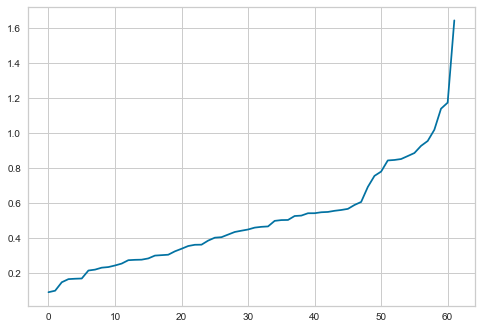

In [20]:
scores = [i[1] for i in songs_to_add]

plt.plot(scores)

In [21]:
song_ids = list()

for i in songs_to_add:
    if i[1] < 0.5:
        song_ids.append(song_names[i[0]])

print(len(song_ids))
print(song_ids)

35
['1jNuMTWsvFvPMwyJcb30FF', '6kM1BzE57Mt5ILbWqzMB14', '2PUoynqedBx15JbPYxzA5v', '37VNAvc9lZC70FcViKcI6f', '3r1ZQqUe14xxssPt2Rkd6j', '3B4B5r2IFmxVxE0fl7wQ6a', '3ggQqaU6hdn5udlJEGt5Ut', '0ZHZ3KsAl0AVBONDmUY3mv', '5dhj9EMLIeq5R1zEo3PSni', '2IrOsuqSttz8KBastkZCzy', '0f5IlhiVWUUq4SGHyrRxIt', '4vF5CLuFgNo6o3Rt2FrNoA', '3aQ46BOZ8C3fOfSFfyEcwq', '5LEHlRPjGcZ5RdagAwXpHS', '0k5TnsKv68q20aE1sJYY7a', '7GkIuSUwvTdG4JoEI7FeJ8', '0RVsJTnSwdLQ6F8ruukszk', '1XhhBtMKmNGM4yfgMZQVxf', '3cYVVPJoyBsDdr5v4GR5wZ', '7CTMv3eJZ3mQ618kZWAb6f', '6Di2mEmryP7AAak4VZMLVJ', '381txcpzL73JjcdV2690sm', '2WGKo3sflN4aUNtesZw4Py', '7hwGHD71FJFBXu1iUDYTYf', '5igYXEgB6IPo7LNtQ71ZMT', '6RuFOroO9VO0aMGEzirLHk', '05XqOIQ7J4mO4ZyOFIoz5L', '3TCIHrNMw2vupAQfg3krlO', '2XwakW5X0FkLa7xGfgDwot', '5qGiDfE4iUmc9ZChUCunTO', '3lyvwZ5DUyj7qlnb49DyRg', '33kX0nz5uT0zqq3EYWvUjf', '0jyK7saNqvRSHlp0HU00z3', '1UH0Sxy2Ahx7T8XQ6csGku', '5tIbsGFsbxljVv1KxUUXKV']
